In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score, accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

In [2]:
# Full data
df = pd.read_csv('data/clean_data.csv').drop('Unnamed: 0',axis=1)

# Features
X = df.drop(['IsCanceled','PreviousBookingsNotCanceled','ReservedRoomType','AssignedRoomType'],axis=1)

# One-Hot Encoded Features
X_dummies = pd.get_dummies(X, drop_first=True)

#Target
y = df['IsCanceled']

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, stratify=y, random_state=44)

#Scaled Features
mm = MinMaxScaler()
X_train_mm = pd.DataFrame(mm.fit_transform(X_train), columns = X_train.columns)
X_test_mm = pd.DataFrame(mm.transform(X_test), columns = X_test.columns)

#Principal Components
pca_95 = PCA(n_components=0.95)
X_train_pca_95 = pca_95.fit_transform(X_train_mm)
X_train_pca_df = pd.DataFrame(X_train_pca_95, columns=[f'PC{i}' for i in range(1, 21)])
X_test_pca_95 = pca_95.transform(X_test_mm)
X_test_pca_df = pd.DataFrame(X_test_pca_95, columns=[f'PC{i}' for i in range(1, 21)])

In [3]:
def plot_results(y_true, y_pred, title):
    """ 
    Plot classification report and confusion matrix for model 
    
    Keyword Arguments:
    y_true = The true values for target
    y_pred = The target predictions of the model
    title = Title to use for Confusion matrix
    
    """
    print('Precision: ',precision_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred))
    
    plt.figure(figsize=(8,4))
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', )
    ax.set_xlabel("Predicted Booking Status", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
    ax.set_ylabel("Actual Booking Status", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])
    ax.set_title("Confusion Matrix - {}".format(title), fontsize=14, pad=20)
    plt.show()

# Baseline Model: Dummy Classifier

Precision:  0.2831734144629066
Recall:  0.5058528428093646


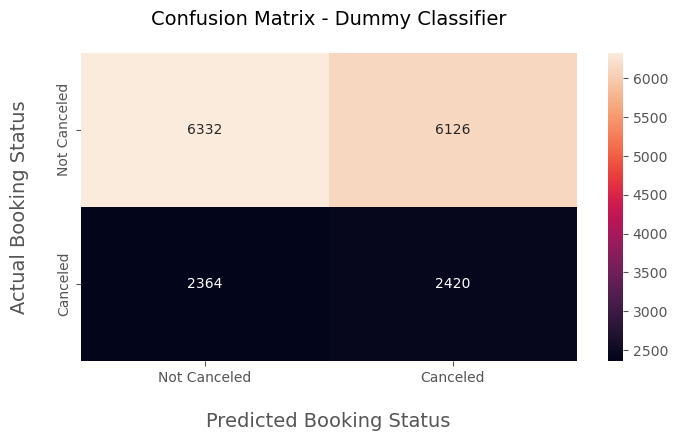

In [4]:
dummy = DummyClassifier(strategy="uniform", random_state=42)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)


plot_results(y_test, dummy_pred, 'Dummy Classifier')

# Model 1: Logistic Regression

Precision:  0.7064777327935222
Recall:  0.43770903010033446


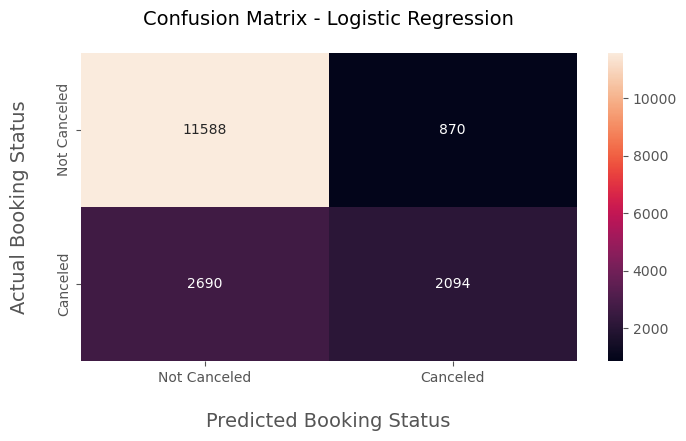

In [5]:
logreg = LogisticRegression(C=3792.690190732246, max_iter=100, penalty='l2', solver='liblinear')
logreg.fit(X_train_mm, y_train)
logreg_pred = logreg.predict(X_test_mm)

plot_results(y_test, logreg_pred, 'Logistic Regression')

In [6]:
log_odds = logreg.coef_[0]
log_odds_df = pd.DataFrame(log_odds, X_train.columns, columns=['coef']).sort_values(by='coef', ascending=False)
log_odds_df.head()

,coef
PreviousCancellations,21.531564
MarketSegment_Undefined,9.213393
DepositType_Non Refund,3.675954
LeadTime,3.445212
StaysInWeekNights,1.880258


In [7]:
log_odds_df.tail()

,coef
Continent_Oceania,-1.439574
TotalOfSpecialRequests,-3.428898
BookingChanges,-4.854303
Continent_Antarctica,-5.577632
RequiredCarParkingSpaces,-80.804189


In [ ]:
# Hyperparameter tuning for logreg

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

#logreg_grid = GridSearchCV(logreg, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
#logreg_grid.fit(X_train_mm,y_train)

In [23]:
# Best hyperparameters
logreg_grid.best_params_

{'C': 3792.690190732246,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear'}

# Model 2: Decision Tree

Precision:  0.7039864291772688
Recall:  0.5204849498327759


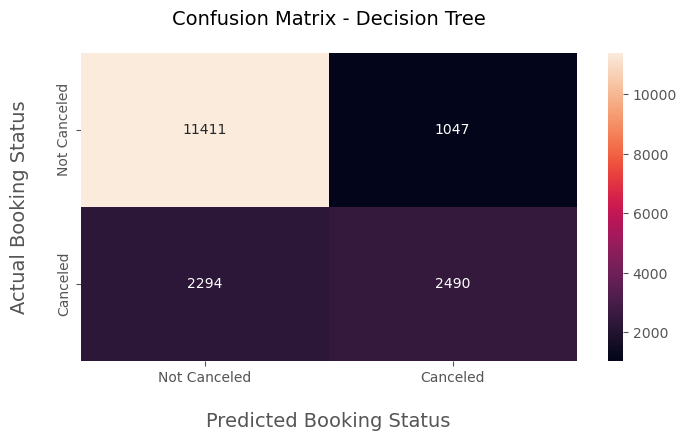

In [8]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=100, random_state=42)
dt.fit(X_train, y_train)
dt_pred= dt.predict(X_test)

plot_results(y_test, dt_pred, 'Decision Tree')

In [49]:
# Hyperparameter tuning for DT

params = {
    'max_depth': [None, 2, 3, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

#dt_grid = GridSearchCV(dt, param_grid=params, cv=5)
#dt_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 10, 20, 50, 100]})

In [59]:
dt_grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [ ]:
#tree.plot_tree(dt_grid)
#plt.show()

# Model 3: Random Forest

Precision:  0.7486115171002631
Recall:  0.5353260869565217


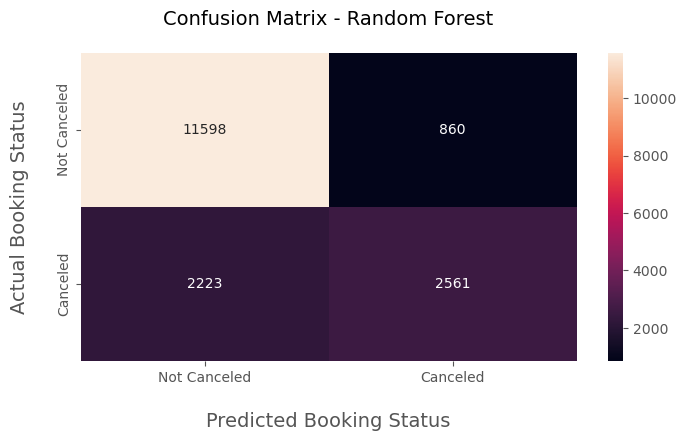

In [9]:
rf = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5, n_estimators=400, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

plot_results(y_test, rf_pred, 'Random Forest')

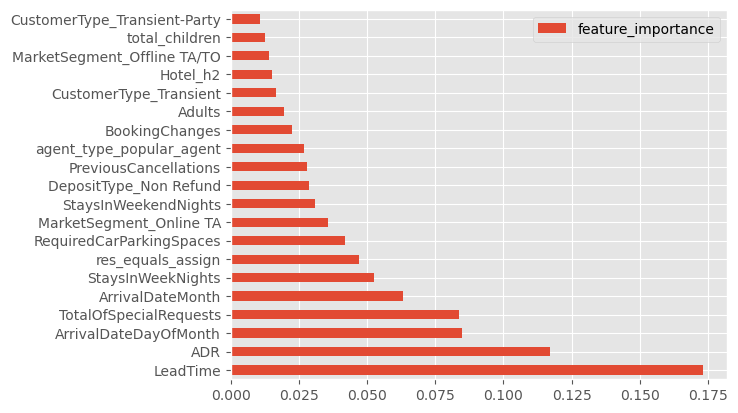

In [10]:
rf_features = pd.DataFrame(rf.feature_importances_, X_train.columns, columns=['feature_importance'])\
              .sort_values(by='feature_importance', ascending=False)

rf_features.head(20).plot(kind='barh')
plt.show()

In [11]:
# Save top 20 features from rf
rf_top_feat = list(rf_features.head(20).index)

In [126]:
# Hyperparameter tuning for rf

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#rf_rand = RandomizedSearchCV(rf, param_distributions=random_grid, cv=5, n_iter=100, n_jobs=-1, random_state=42)
#rf_rand.fit(X_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [133]:
rf_rand.best_estimator_

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=400, random_state=42)

# Model 4: XGboost

Precision:  0.7043189368770764
Recall:  0.5760869565217391


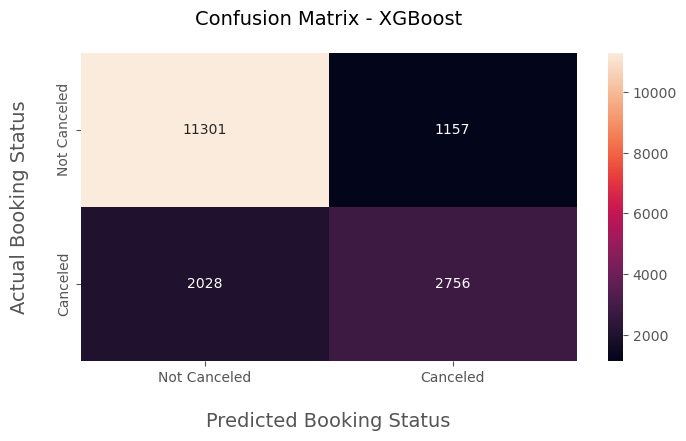

In [12]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_estimators=200, max_depth=12,
                   reg_lambda = 100, reg_alpha = 0.01, learning_rate=1, gamma=1, colsample_bytree = 0.5)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


plot_results(y_test, xgb_pred, 'XGBoost')

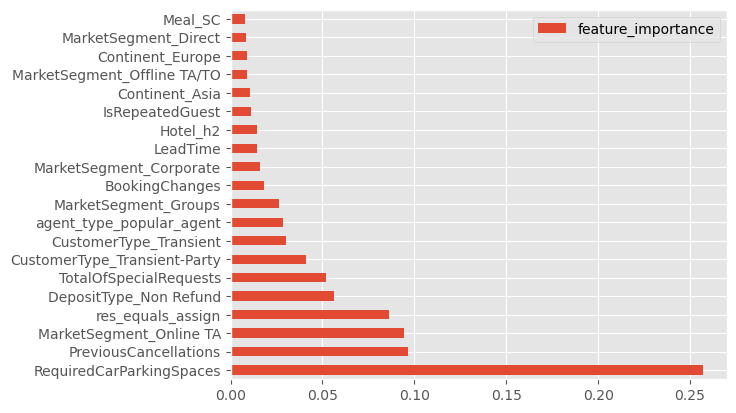

In [13]:
# Plot feature importance
xgb_features = pd.DataFrame(xgb.feature_importances_, 
             X_train.columns, 
             columns=['feature_importance'])\
            .sort_values(by='feature_importance', ascending=False)
xgb_features.head(20).plot(kind='barh')
plt.show()

In [14]:
# Save top 20 features from xgb
xgb_top_feat = list(xgb_features.head(20).index)

In [17]:
# Hyperparameter tuning for xgb

# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # Number of Trees in Ensemble (number of boosting rounds)
    "n_estimators" : [50, 100, 200, 300]}

#xgb_rand = RandomizedSearchCV(xgb, param_distributions=param_grid, scoring='recall' , n_iter=50, n_jobs=-1, cv=5, verbose=1)
#xgb_rand.fit(X_train, y_train)

In [23]:
xgb_rand.best_params_

{'reg_lambda': 100,
 'reg_alpha': 0.01,
 'n_estimators': 200,
 'max_depth': 12,
 'learning_rate': 1,
 'gamma': 0.0,
 'colsample_bytree': 0.5}

# Model 5: LightGBM

Precision:  0.5783132530120482
Recall:  0.7725752508361204


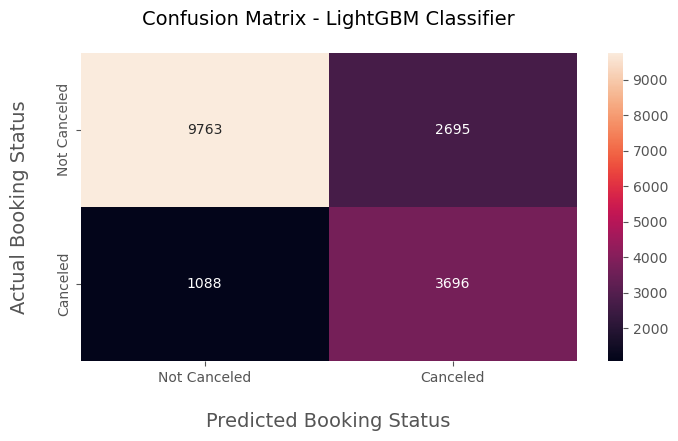

In [15]:
lgbm = LGBMClassifier(learning_rate=0.4, max_depth=5, n_estimators=300, num_leaves=10,
                     reg_alpha=0,reg_lambda=0, boosting_type='gbdt', is_unbalance=True)

lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

plot_results(y_test, lgbm_pred, 'LightGBM Classifier')

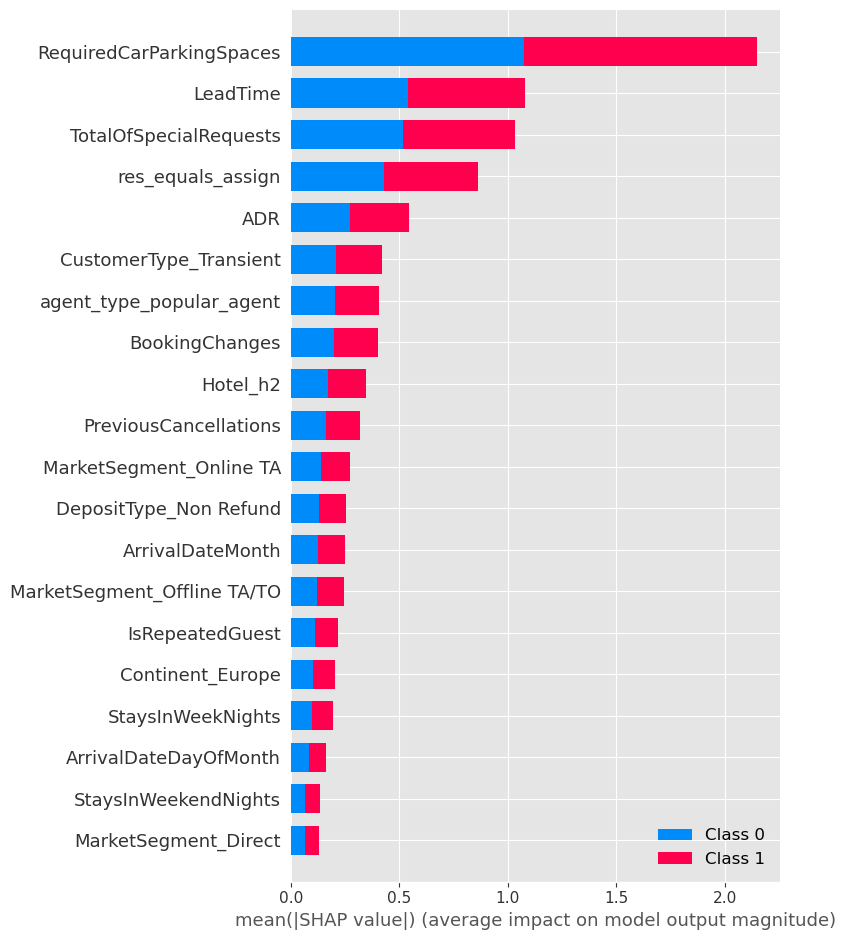

In [30]:
shap.initjs()

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

In [ ]:
params_lgb={'num_leaves':[10,20,30,40],
             'max_depth':[1,2,4,-1],
             'n_estimators':[50,100,150,200],
             'learning_rate':[0.01,0.1,0.2],
             'class_weight':['balanced'],
              'reg_alpha':[0,0.01,0.1],
              'reg_lambda':[0,0.01,0.1]
             }

# Comparing Models

In [16]:
# Predict on training set to check for overfitting
dummy_train_pred = dummy.predict(X_train)
logreg_train_pred = logreg.predict(X_train_mm)
dt_train_pred = dt.predict(X_train)
rf_train_pred = rf.predict(X_train)
xgb_train_pred = xgb.predict(X_train)
lgbm_train_pred = lgbm.predict(X_train)

In [17]:
model_preds_train = [dummy_train_pred, logreg_train_pred, dt_train_pred, rf_train_pred, xgb_train_pred,lgbm_train_pred]
model_preds_test = [dummy_pred,logreg_pred, dt_pred, rf_pred, xgb_pred, lgbm_pred]


accuracy_train = []
accuracy_test = []

precision_train = []
precision_test = []

recall_train = []
recall_test = []

auc_train = []
auc_test = []

for pred in model_preds_train:
    acc = accuracy_score(y_train, pred)
    accuracy_train.append(acc)
    
    prec = precision_score(y_train, pred)
    precision_train.append(prec)
    
    rec = recall_score(y_train, pred)
    recall_train.append(rec)
    
    auc = roc_auc_score(y_train, pred)
    auc_train.append(auc)
    
for pred in model_preds_test:
    acc = accuracy_score(y_test, pred)
    accuracy_test.append(acc)
    
    prec = precision_score(y_test, pred)
    precision_test.append(prec)
    
    rec = recall_score(y_test, pred)
    recall_test.append(rec)
    
    auc = roc_auc_score(y_test, pred)
    auc_test.append(auc)

full_features_results = pd.DataFrame(index=['Dummy Classifier','Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'])
full_features_results['Train Recall'] = recall_train
full_features_results['Test Recall'] = recall_test
full_features_results['Train Precision'] = precision_train
full_features_results['Test Precision'] = precision_test
full_features_results['Train Accuracy'] = accuracy_train
full_features_results['Test Accuracy'] = accuracy_test
full_features_results['Train AUC'] = auc_train
full_features_results['Test AUC'] = auc_test

In [27]:
full_features_results.style.background_gradient(subset=['Test Recall', 'Test Precision', 'Test Accuracy','Test AUC'])

,Train Recall,Test Recall,Train Precision,Test Precision,Train Accuracy,Test Accuracy,Train AUC,Test AUC
Dummy Classifier,0.505906,0.505853,0.280166,0.283173,0.502284,0.507598,0.503399,0.507060
Logistic Regression,0.447110,0.437709,0.704695,0.706478,0.794620,0.793527,0.687583,0.683937
Decision Tree,0.543535,0.520485,0.718381,0.703986,0.814239,0.806229,0.730859,0.718221
Random Forest,0.819588,0.535326,0.936407,0.748612,0.934503,0.821192,0.899108,0.733147
XGBoost,0.703408,0.576087,0.833788,0.704319,0.878808,0.815277,0.824783,0.741607
LightGBM,0.829309,0.772575,0.620595,0.578313,0.811977,0.780594,0.817316,0.778124


In [28]:
rf_cv_recall = cross_val_score(rf, X_train, y_train, cv=5, scoring='recall', n_jobs=-1).mean()
rf_cv_recall

0.543796403002793

In [29]:
xgb_cv_recall = cross_val_score(xgb, X_train, y_train, cv=5, scoring='recall', n_jobs=-1).mean()
xgb_cv_recall

0.5730638264915789

In [72]:
lgbm_cv_recall = cross_val_score(lgbm, X_train, y_train, cv=5, scoring='recall', n_jobs=-1).mean()
lgbm_cv_recall

0.7694679220237641

# Modeling Attempts after resampling (SMOTE)

In [73]:
from imblearn.over_sampling import SMOTE, SVMSMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [74]:
y_train_resampled.value_counts()

0    49831
1    49831
Name: IsCanceled, dtype: int64

Precision:  0.6540622299049266
Recall:  0.6327341137123745


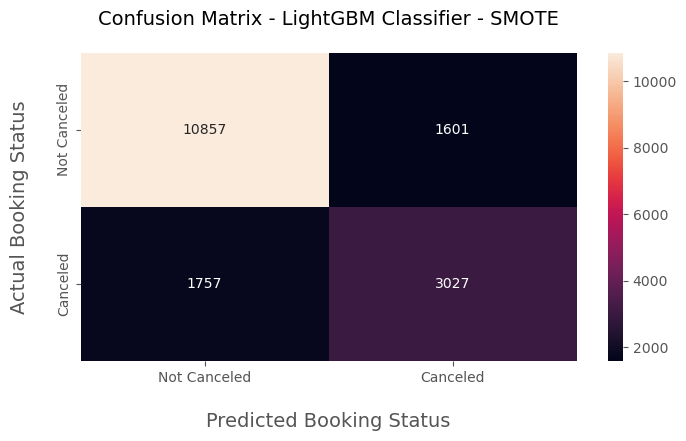

In [137]:
lgbm_smote = LGBMClassifier()

lgbm.fit(X_train_resampled, y_train_resampled)
lgbm_pred_smote = lgbm.predict(X_test)

plot_results(y_test, lgbm_pred_smote, 'LightGBM Classifier - SMOTE')

Precision:  0.6860753780185059
Recall:  0.6354515050167224


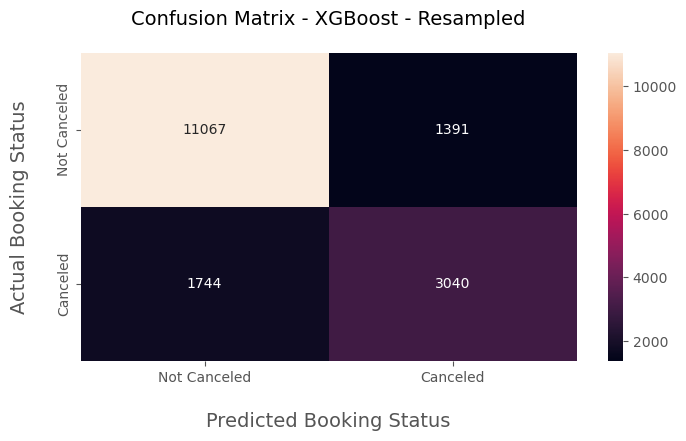

In [81]:
xgb_smote = XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=18,reg_alpha=0.01,
                          reg_lambda=1, random_state=42)
xgb_smote.fit(X_train_resampled, y_train_resampled)
xgb_smote_pred = xgb_smote.predict(X_test)

plot_results(y_test, xgb_smote_pred, 'XGBoost - Resampled')

In [67]:
# Bayesian Optimization for XGBoost

from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])}
    
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    
# Objective function
def objective(params):
    
    xgboost = XGBClassifier(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train_resampled, 
                            y=y_train_resampled, 
                            cv=kfold, 
                            scoring='recall', 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = Trials())

100%|██| 100/100 [1:35:25<00:00, 57.25s/trial, best loss: -0.8591840842332717]


In [68]:
print(best)
print(space_eval(space, best))

{'colsample_bytree': 2, 'gamma': 2, 'learning_rate': 3, 'max_depth': 5, 'reg_alpha': 1, 'reg_lambda': 3}
{'colsample_bytree': 0.5, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 18, 'reg_alpha': 0.01, 'reg_lambda': 1}
